# Spoken Digit Classification

## Imports and dataset download

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
import scipy as sp

# Classifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

In [0]:
! git clone -q https://github.com/Jakobovski/free-spoken-digit-dataset

os.environ['KAGGLE_USERNAME'] = "andreacoppola"
os.environ['KAGGLE_KEY'] = "8d841874df721c79c79ada9beec21904"
!kaggle datasets download -d andreacoppola/googlespokendigits
!unzip googlespokendigits.zip

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


## Dataset import 

The informations about the audio track are retrieved from the name using the following regexp
```python
'([0-9]+)_([a-z]+)_([0-9]+).wav'
```
With this we can retrieve from the 3 groups
```python
# Digit Label
regexp.search(filename).group(1)
# Spearker Name (maybe we'll need this later while analyzing the data?)
regexp.search(filename).group(2)
# File Index
regexp.search(filename).group(3)
```


In [0]:
# recordings directory
directory = 'free-spoken-digit-dataset/recordings/'
# regexp matching {digitLabel}_{speakerName}_{index}.wav
regexp = re.compile('([0-9]+)_([a-z]+)_([0-9]+).wav') 

labels  = []
audios  = []
indexes = []
sizes   = []
names   = []

# setup progress bar
pbar = tqdm(desc='Loading audio samples')
pbar.reset(total=len(os.listdir(directory))) 

for f in os.listdir(directory):
  if f.endswith(".wav"): 
    labels.append(regexp.search(f).group(1))       # Take the first group (label)
    names.append(regexp.search(f).group(2))        # Take the second groun (name)
    indexes.append(int(regexp.search(f).group(3))) # Take the last group (index)
    x, sr = librosa.load(directory+f, sr=None)     # Load audio file
    sizes.append(x.size)
    audios.append(x)                               # Put it in the list
  pbar.update()                                  # updates progress bar
pbar.refresh();

# python lists to np.ndarray
Y = np.asarray(labels)
X = np.asarray(audios)
I = np.asarray(indexes)

Here we're doing a train-test split using the conditions stated in the github repository

In [0]:
# condition stated in the git repository for the test/train subdivision
is_in_test  = I <= 4
is_in_train = I >  4

Y_test, Y_train = Y[is_in_test], Y[is_in_train]
X_test, X_train = X[is_in_test], X[is_in_train]

In [0]:
N = np.asarray(names)
N_test, N_train = N[is_in_test], N[is_in_train]

Download of spoken digits from [Google Speech Commands Dataset](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html)  

In [0]:
X_GD = np.load('X_google_dataset.npy', allow_pickle=True)
Y_GD = np.load('Y_google_dataset.npy', allow_pickle=True)

## Preprocessing



In [0]:
# python lists to np.ndarray
Y = np.asarray(labels)
X = np.asarray(audios)
I = np.asarray(indexes)

'''
Create an array (L) of empty audio tracks of 8000 samples
For each audio track in X:
  if the track is too long, trim it to be 1 second long (8000 samples)
  Then fill the first
'''
# L is the trimmed and zero-padded dataset
L = np.zeros((X.size, 8000))
pbar = tqdm(desc='Zero Padding')
pbar.reset(total=len(X))
for i in range(len(X)):
  if(X[i].size>8000): X[i] = X[i][0:8000] 
  L[i, 0:X[i].size] = X[i]                 
  pbar.update();                             
pbar.refresh();

In [0]:
is_in_test  = I <= 4
is_in_train = I >  4

Y_test, Y_train = Y[is_in_test], Y[is_in_train]
L_test, L_train = L[is_in_test], L[is_in_train]  # Trimmed and zero-padded dataset
X_test, X_train = X[is_in_test], X[is_in_train]  # Original dataset

## Features extraction

### Functions

MFCC

In [0]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft(
        audio,
        window='hamming',
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=4000,
    )

    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X)

    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]

    return mfcc

In [0]:
def my_feature_implementation(data, fs):
  #TODO
  return feature

In [0]:
def feature_extraction(data, feat_type):
  pbar = tqdm(desc='Feature extraction')
  size = len(data)
  pbar.reset(total=size)

  Fs = 8000
  features = None
  if(feat_type == "mfcc20"):
    n_mfcc = 20
    features = np.zeros((size, n_mfcc))
    for i in range(size):
      mfcc = compute_mfcc(data[i], Fs, n_mfcc)
      features[i, :] = np.mean(mfcc, axis=1)
      pbar.update()
    pbar.refresh()
  if(feat_type == "mfcc13"):
    n_mfcc = 13
    features = np.zeros((size, n_mfcc))
    for i in range(size):
      mfcc = compute_mfcc(data[i], Fs, n_mfcc)
      features[i, :] = np.mean(mfcc, axis=1)
      pbar.update()
    pbar.refresh()
  if(feat_type == "my_feature"):
    ...

  
  return features

## Classifier

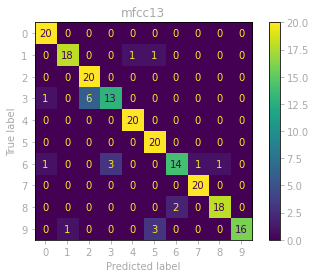

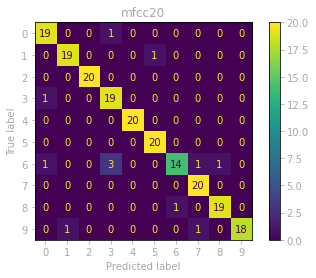

In [0]:
feature_method = ["mfcc13", "mfcc20"]

# Train section
train_feature_list = []
for fm in feature_method:
  train_feature = feature_extraction(X_train, fm)
  train_feature_list.append(train_feature)

scaler_list = []
for i in range(len(feature_method)):
  scaler = MinMaxScaler()
  scaler.fit(train_feature_list[i])
  scaler.transform(train_feature_list[i])
  scaler_list.append(scaler)

clf_list = []
for i in range(len(feature_method)):
  clf = svm.SVC()
  clf.fit(train_feature_list[i], Y_train)
  clf_list.append(clf)


# Test section
for i in range(len(feature_method)):
  test_features = feature_extraction(X_test, feature_method[i])
  scaler_list[i].transform(test_features)

  disp = plot_confusion_matrix(clf_list[i], test_features, Y_test)
  disp.ax_.set_title(feature_method[i])
  plt.show()

  y_pred = clf_list[i].predict(test_features)
  CM.append((feature_method[i], confusion_matrix(Y_test, y_pred)))
  
#for m in CM:
#  print(m[0], ":\n", pd.DataFrame(m[1]))
  
  

### Analysis

In [0]:
mispred = X_test[y_pred != Y_test]
pred_label = y_pred[y_pred!=Y_test]
speaker = N_test[y_pred!=Y_test]

print("Predicted Label:", pred_label)
print("Speaker:", speaker)

clip = np.zeros((mispred.size*10000))
r = 0
for x in mispred:
  clip[r:r+x.size] = x/np.max(x)
  r = r+ x.size+4000
Audio(clip, rate=8000)

Predicted Label: ['3' '3' '8' '6' '5' '7' '0' '0' '3' '7' '3' '1']
Speaker: ['yweweler' 'yweweler' 'nicolas' 'yweweler' 'yweweler' 'jackson' 'nicolas'
 'jackson' 'nicolas' 'yweweler' 'yweweler' 'yweweler']


## Style

In [0]:
import matplotlib as mpl
COLOR = 'darkgrey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR